In [10]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import math
import seaborn as sns

from util import *

Text(0.5, 1.0, 'Ground Truth')

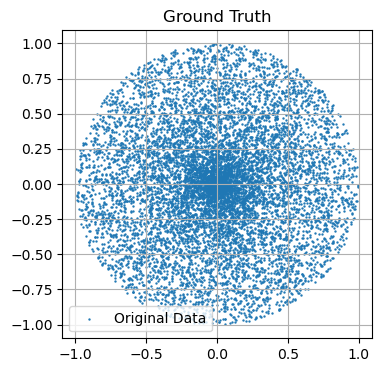

In [11]:
r = np.random.uniform(low = 0,high = 1, size = 10000)
theta = np.random.uniform(low = 0,high = 2*np.pi, size = 10000)
X = r*np.cos(theta)
Y = r*np.sin(theta)


Data_original = np.concatenate([X[:,None],Y[:,None]],axis = -1)

plt.figure(figsize=(4,4))
plt.scatter(Data_original[:,0],Data_original[:,1], s= 0.5, label = "Original Data")
plt.grid("True")
plt.legend()
plt.title("Ground Truth")

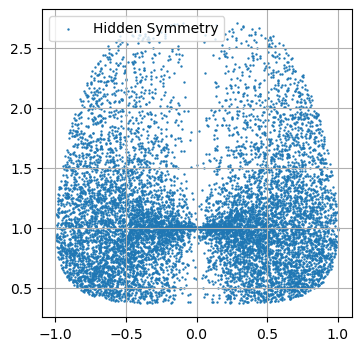

In [15]:
X_new = np.sign(X)*(np.abs(X.copy()))**(1/2) # Coordinate Perturbation
Y_new = np.exp(Y.copy()) # Coordinate Perturbation
Data_perturbed = np.concatenate([X_new[:,None],Y_new[:,None]],axis = -1)

plt.figure(figsize=(4,4))
# plt.scatter(Data_original[:,0],Data_original[:,1], s= 0.5, label = "Original Data")
plt.scatter(Data_perturbed[:,0],Data_perturbed[:,1], s= 0.5, label = "Hidden Symmetry")
plt.grid("True")
plt.legend()

In [16]:
def psi(z):
    """
    The conserved charge in the new coordinate system
    """
    X_old_square = ((z[:,0])**2)**2
    Y_old_square = (torch.log(z[:,1])**2)
    
    return ((X_old_square+Y_old_square)**0.5)[:,None]

In [17]:
# Complete supervised train technique
tensor_original = torch.Tensor(Data_original)
tensor_perturbed = torch.Tensor(Data_perturbed)

dataset = torch.utils.data.TensorDataset(tensor_original, tensor_perturbed)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

device = "cuda:2"

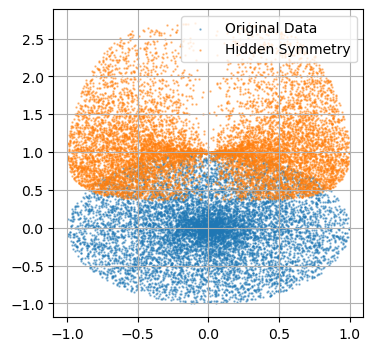

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(tensor_original[:,0].detach().cpu(),tensor_original[:,1].detach().cpu(), s= 0.5, label = "Original Data", alpha = 0.5)
plt.scatter(tensor_perturbed[:,0].detach().cpu(),tensor_perturbed[:,1].detach().cpu(), s= 0.5, label = "Hidden Symmetry", alpha = 0.5)
plt.grid("True")
plt.legend()

In [ ]:
NUM_GEN = 1
model_symmetry = Operator(feature_size=2,
                          feature_multipier=4,
                          number_of_blocks=4,
                          num_generators=NUM_GEN,
                          normalise_enc=True,
                          normalise_dec=False,
                          LOSS_MODE="MSE"
                         ).to(device)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)
scheduler_symmetry = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_symmetry, mode='min', factor=0.1, patience=10, verbose=True)

model_symmetry = train_for_hidden_symmetry(train_dataloader = train_dataloader,
                                           visualisation_set = tensor_perturbed,
                                           optimiser_symmetry = optimiser_symmetry,
                                           model_symmetry = model_symmetry,
                                           psi = psi,
                                           NUM_GEN = NUM_GEN,
                                           device = device,
                                           verbose= True,
                                           NEpochs = 2000,
                             )


### Looking at specific examples

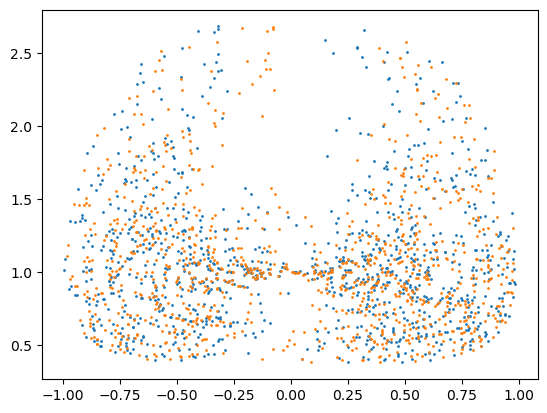

In [12]:
perturbed = tensor_perturbed[:1024,:].to(device)
theta = [(0.05*torch.ones(perturbed.shape[0],device = device)) for i in range(NUM_GEN)]  #Sampling

enc, trans, dec, dec_trans = model_symmetry(Z = perturbed,
                                            theta = theta)

original = perturbed.to("cpu").detach()
transformed = dec_trans.to("cpu").detach()

plt.scatter(original[:,0],original[:,1],s=1)
plt.scatter(transformed[:,0],transformed[:,1],s=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


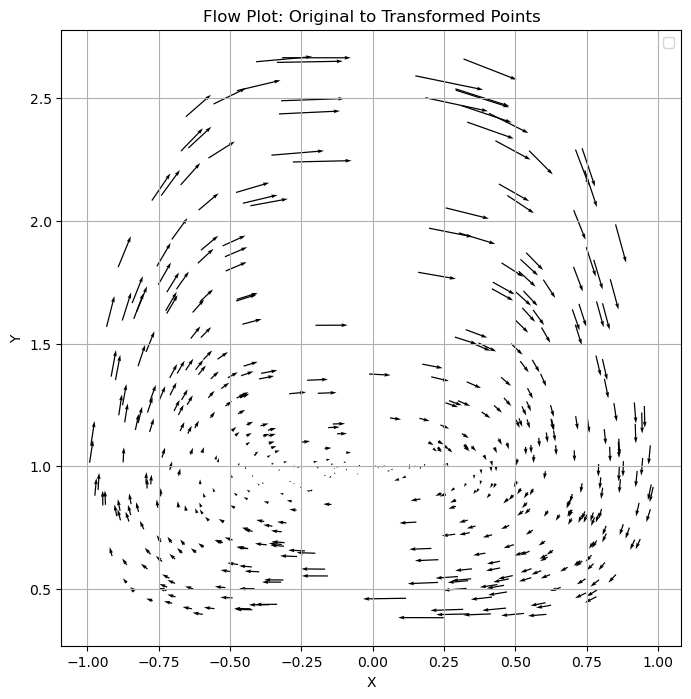

In [14]:
plt.figure(figsize=(8, 8))
magni = 1
dx = transformed[:500, 0] - original[:500, 0]
dy = transformed[:500, 1] - original[:500, 1]
plt.quiver(original[:500, 0], original[:500, 1], magni*dx, magni*dy, angles='xy', scale_units='xy', scale=1, width=0.002, alpha=1, color='black')

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Flow Plot: Original to Transformed Points")
# plt.axis('equal')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


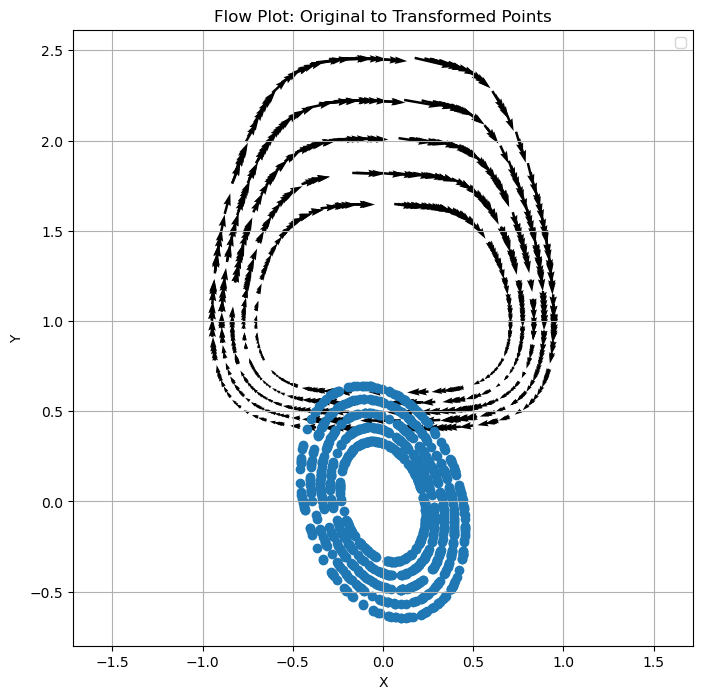

In [19]:
r = np.random.choice([0.5,0.6,0.7,0.8,0.9],1000)
theta = np.random.uniform(low = 0,high = 2*np.pi,size=1000)
X = r*np.cos(theta)
Y = r*np.sin(theta)

X_new = np.sign(X)*(np.abs(X.copy()))**(1/2) # Coordinate Perturbation
Y_new = np.exp(Y.copy()) # Coordinate Perturbation
Data_vis = torch.Tensor(np.concatenate([X_new[:,None],Y_new[:,None]],axis = -1))


theta = [(0.05*torch.ones(Data_vis.shape[0],device = device)) for i in range(NUM_GEN)]  #Sampling

enc, trans, dec, dec_trans = model_symmetry(Z = Data_vis.to(device),
                                            theta = theta)

original = Data_vis.detach()
transformed = dec_trans.to("cpu").detach()


plt.figure(figsize=(8, 8))
magni = 1
dx = transformed[:, 0] - original[:, 0]
dy = transformed[:, 1] - original[:, 1]
plt.quiver(original[:, 0], original[:, 1], magni*dx, magni*dy, angles='xy', scale_units='xy', scale=1, width=0.004, alpha=1, color='black')
plt.scatter(enc[:,0].detach().cpu(),enc[:,1].detach().cpu())
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Flow Plot: Original to Transformed Points")
plt.axis('equal')
plt.grid(True)
plt.show()